## 使用QLORA訓練白話文和文言文互轉的模型(台大資工所2024年應用深度學習作業3)
### 1. 作業目標
- 本次作業目標是使用QLORA訓練一個白話文和文言文互轉的模型。
- 使用的基礎模型是`zake7749/gemma-2-2b-it-chinese-kyara-dpo`，這是一個Google Gemma2經過Instrunction Tuned及DPO之後的模型。
- 本次作業的資料集是台大資工作業提供的，並沒有經過資料清理，是用簡體硬轉成繁體的，資料集問題很多，這是一個包含白話文和文言文的資料集。
### 2. 作業步驟
- 本次作業的步驟如下：
  1. 資料前處理
  2. 使用QLORA訓練模型
  3. 模型測試
### 3. 訓練監控
- 本次作業的訓練監控如下：
  1. 訓練過程中的loss
  2. 使用wandb記錄訓練過程
  3. 調整各種參數觀察訓練結果


In [ ]:
!pip install transformers datasets torch bitsandbytes peft wandb trl flash-attn nvidia-ml-py3

## 抓取訓練資料，裡面包含五萬筆白話文->文言文資料

In [ ]:
!wget https://github.com/shhuangmust/AI/raw/refs/heads/master/train.json

- 採用gemma-2-2b-it-chinese-kyara-dpo基礎模型
- 4bit的量化模型來節省訓練記憶體
- 要產生文言文，因此採用AutoModelForCausalLM

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model_id = "zake7749/gemma-2-2b-it-chinese-kyara-dpo"



model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config,
                      attn_implementation='eager',
                      cache_implementation=None,
                      use_cache=False,)

tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_token=True)
model.to('cuda')

In [ ]:
print(model)

## 讀取資料
- 將資料轉換成gemma2的讀取格式

In [ ]:
from datasets import load_dataset
dataset = load_dataset('json', data_files="train.json", split="train").shuffle(seed=42)

def generate_prompt(data_point):
    prefix_text = '你是一個使用繁體中文的人工智慧助理，下面是問題的描述，以及對應的答案，請照著問題並且回答答案。\n\n'
    text = f"<start_of_turn>user {prefix_text} {data_point['instruction']} <end_of_turn>\n<start_of_turn>model {data_point['output']} <end_of_turn>"
    return text
# Add the 'prompt' column to the dataset
text_column = [generate_prompt(data_point) for data_point in dataset]
dataset = dataset.add_column("prompt", text_column)
# Tokenize the dataset
dataset = dataset.shuffle(seed=1234)
dataset = dataset.map(lambda samples: tokenizer(samples["prompt"]), batched=True)
# Split the dataset into training and testing
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset["train"]
test_data = dataset["test"]

In [ ]:
print(train_data[200])

## 找出所有可以進行QLora訓練的層

In [ ]:
def find_all_linear_names(peft_model, int4=False, int8=False):
    """Find all linear layer names in the model. reference from qlora paper."""
    cls = torch.nn.Linear
    if int4 or int8:
        import bitsandbytes as bnb
        if int4:
            cls = bnb.nn.Linear4bit
        elif int8:
            cls = bnb.nn.Linear8bitLt
    lora_module_names = set()
    for name, module in peft_model.named_modules():
        if isinstance(module, cls):
            # last layer is not add to lora_module_names
            if 'lm_head' in name:
                continue
            if 'output_layer' in name:
                continue
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    return sorted(lora_module_names)

In [ ]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

model.enable_input_require_grads()
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)
modules = find_all_linear_names(model)  # Get modules to apply LoRA to
lora_config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=modules,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
peft_model = get_peft_model(model, lora_config)

In [ ]:
print(peft_model)

## 列出可訓練的參數數目跟比例

In [ ]:
peft_model.print_trainable_parameters()

In [ ]:
print(modules)

## 進行PEFT訓練
- 採用trl套件
- 可修改max_steps以調整訓練次數

In [ ]:
from trl import SFTConfig
import transformers
from trl import SFTTrainer

trainer = SFTTrainer(
    model=peft_model,
    train_dataset=train_data,
    eval_dataset=test_data,
    peft_config=lora_config,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        max_steps=100,
        learning_rate=2e-4,
        output_dir="output1",
        # dataset_text_field="prompt",
        optim="paged_adamw_32bit",
        save_strategy="steps",
        report_to=None,
        #report_to="wandb",
        logging_steps=1,
        packing=False,
        gradient_checkpointing=True,
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
trainer.train()

## 儲存Adapter
- Huggingface的Token，<font color=red>一定要包含『write』權限</font>
- <font color=red>??????????</font>/peft-model-repo，?????????請輸入自己在huggingface的帳號

In [ ]:
peft_model.save_pretrained("peft_model")
repo_name = "shhuangmust/peft-model-repo"  # 替換為你的 repository 名稱
save_directory = "./peft_model"             # 模型儲存的本地路徑

# 上傳模型到 Hugging Face
peft_model.push_to_hub(repo_name)

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
merged_model = PeftModel.from_pretrained(base_model, "output1/checkpoint-100")
merged_model = merged_model.merge_and_unload()


## 一般來說只需要上傳Adapter即可，要使用LLM時，Adapter+基礎模型即可。這邊直接把兩者合併為(merged_model)

In [ ]:
merged_model.save_pretrained("merged_model", safe_serialization=True, push_to_hub=True)
tokenizer.save_pretrained("merged_model", push_to_hub=True)

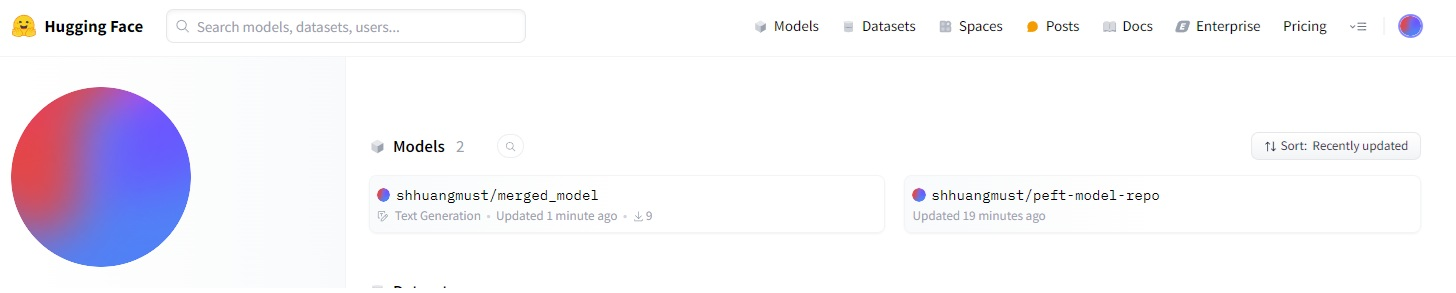